# LRF Compute of MPAS Experiments

## import package

In [132]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import joblib

from joblib import Parallel, delayed
from scipy.interpolate import interp1d

## functions

### load data functions

In [133]:
def load_data(path: str, var: str, lat_lim):
    with nc.Dataset(f'{path}{var}.nc', 'r', mmap=True) as f:
        return f.variables[var][:, :, lat_lim, :]

### Running mean

In [134]:
def running_mean(
    data: np.ndarray,
    window_size: int, axis: int
    )-> np.ndarray:
    
    kernel = np.ones(window_size) / window_size
    
    arr_conv = np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode='same'),
        axis, data
    )
    
    return arr_conv

### interpolation

In [135]:
def interpolate(data, lev_org, lev_itp):
    data_itp = interp1d(lev_org[::-1], data[::-1], axis=0)(lev_itp)

    return data_itp

### normal equation

In [136]:
def NormEqu(tend, state):
    comp1 = tend @ state.T
    comp2 = np.linalg.inv(state @ state.T + np.diag(np.array([0.1]).repeat(state.shape[0])))

    return comp1 @ comp2

## load data

In [137]:
case = 'NSC' # case name

path = f'/work/b11209013/MPAS/merged_data/{case}/' # file path of data
var_list = ['qv', 'theta', 'rqvcuten', 'rthcuten', 'rthratenlw', 'rthratensw'] # variable list

# load dimension
with nc.Dataset(f'{path}qv.nc', 'r', mmap=True) as f:
    lon  = f.variables['lon'][:]
    lat  = f.variables['lat'][:]
    lev  = f.variables['lev'][:]
    time = f.variables['time'][:]

lat_lim = np.where((lat >= -5) & (lat <= 5))[0] # latitude range
lat = lat[lat_lim]

# load variables
data = Parallel(n_jobs=36)(
    delayed(load_data)(path, var, lat_lim)
    for var in var_list
    )

data = {
    var: data[i]
    for i, var in enumerate(var_list)
}

ltime, llev, llat, llon = data['qv'].shape

## Running Mean over data

### running mean over longitude

In [138]:
data_running_lon = Parallel(n_jobs=12)(
    delayed(running_mean)(data[var], 10, 3)
    for var in var_list
    )

del data

### running mean over latitude

In [139]:
data_running = Parallel(n_jobs=12)(
    delayed(running_mean)(data_running_lon[i], 10, 3)
    for i in range(len(var_list))
    )

data_running = {
    var: data_running[i].mean(axis=2)
    for i, var in enumerate(var_list)
}

## Unit Conversion

In [140]:
theta2t = (1000/lev[None, :, None])**(-0.286)

data_convert = {
    't'        : data_running['theta']*theta2t,
    'qv'       : data_running['qv']*1000,
    'rqvcuten' : data_running['rqvcuten']*1000*86400,
    'rtcuten'  : data_running["rthcuten"]*86400*theta2t,
    'rtratenlw': data_running["rthratenlw"]*86400*theta2t,
    'rtratensw': data_running["rthratensw"]*86400*theta2t
}

var_list = data_convert.keys() # update variable list

del data_running, data_running_lon

## Compute anomaly

In [141]:
data_ano = {var: data_convert[var] - data_convert[var].mean() for var in var_list}

del data_convert
print(data_ano['t'].shape)

(368, 38, 720)


## interpolate

### permute data

In [142]:
data_ano = {
    var: data_ano[var].transpose((1, 0, 2)).reshape((llev, -1))
    for var in var_list}


### interpolate

In [143]:
lev_itp = np.linspace(150, 1000, 18)

data_itp = Parallel(n_jobs=12)(
    delayed(interpolate)(data_ano[var], lev, lev_itp)
    for var in var_list
    )

data_itp = {var: data_itp[i] for i, var in enumerate(var_list)}

del data_ano

## Compute linear response function

In [144]:
# form state vector and tendency
state_vec = np.concatenate((data_itp["t"], data_itp["qv"]), axis=0)
conv_tend = np.concatenate((data_itp["rtcuten"], data_itp["rqvcuten"]), axis=0)

## linear response function
lw_lrf = NormEqu(data_itp["rtratenlw"], state_vec)
sw_lrf = NormEqu(data_itp["rtratensw"], state_vec)
cu_lrf = NormEqu(conv_tend, state_vec)

lw_lrf[:, 18:22] = np.nan
sw_lrf[:, 18:22] = np.nan
cu_lrf[:, 18:22] = np.nan

lrf_dict = {
    "lev"   : lev_itp,
    "lw_lrf": lw_lrf,
    "sw_lrf": sw_lrf,
    "cu_lrf": cu_lrf
}

## save lrf as pkl

In [145]:
joblib.dump(lrf_dict, f"/home/b11209013/2024_Research/MPAS/LRF/LRF_file/lrf_{case}.pkl")

['/home/b11209013/2024_Research/MPAS/LRF/LRF_file/lrf_NSC.pkl']

## plot image

### plot setting

In [146]:
plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

image_path = f"/home/b11209013/2024_Research/MPAS/LRF/image/{case}/"

half = int(lev_itp.size)
print(half)

18


### plot

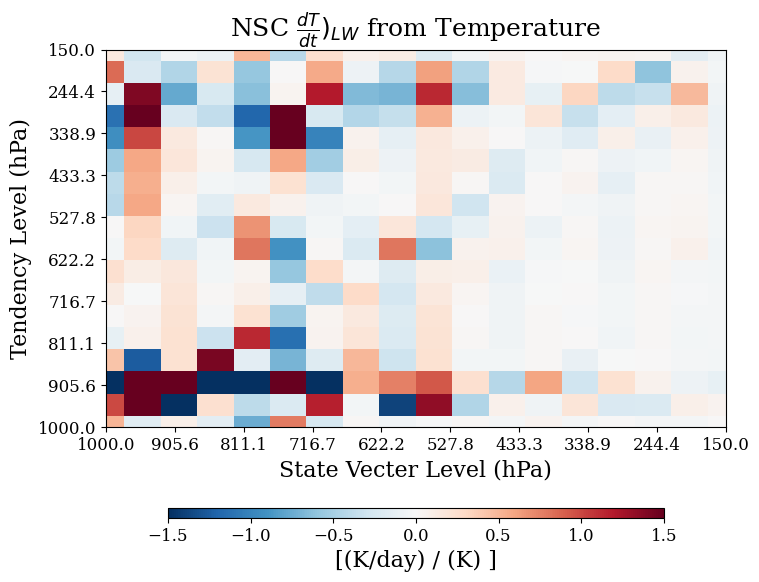

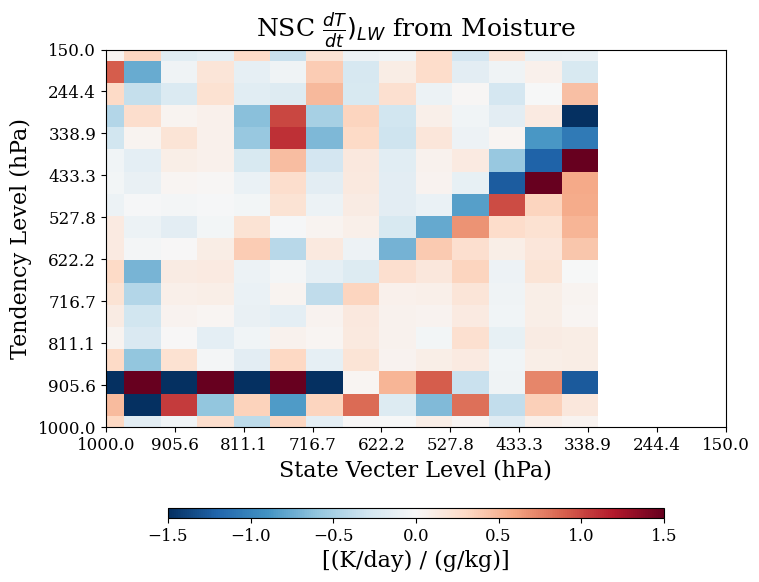

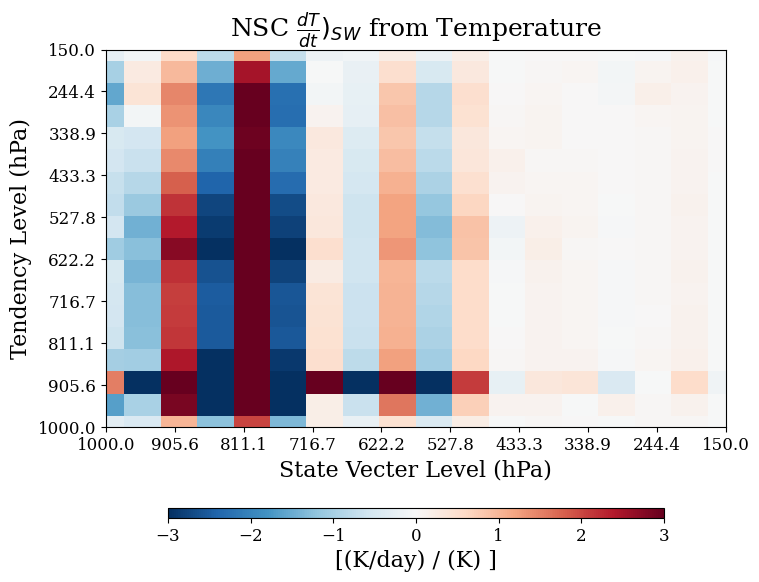

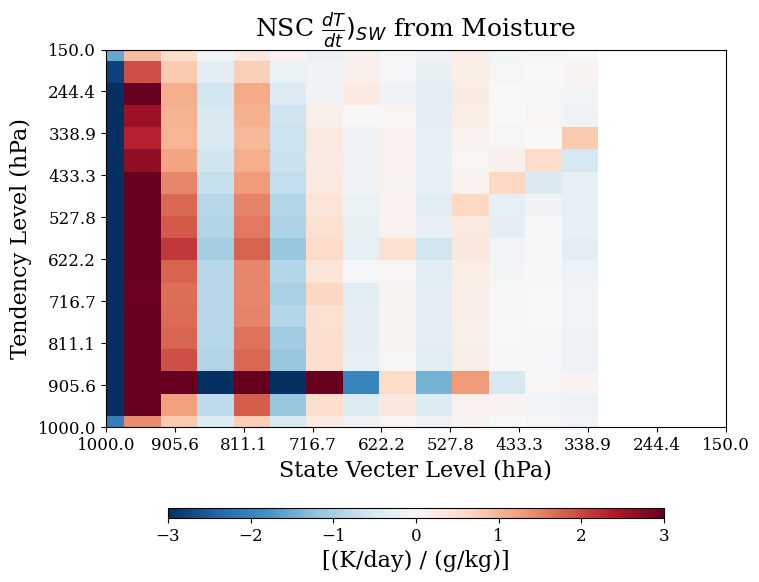

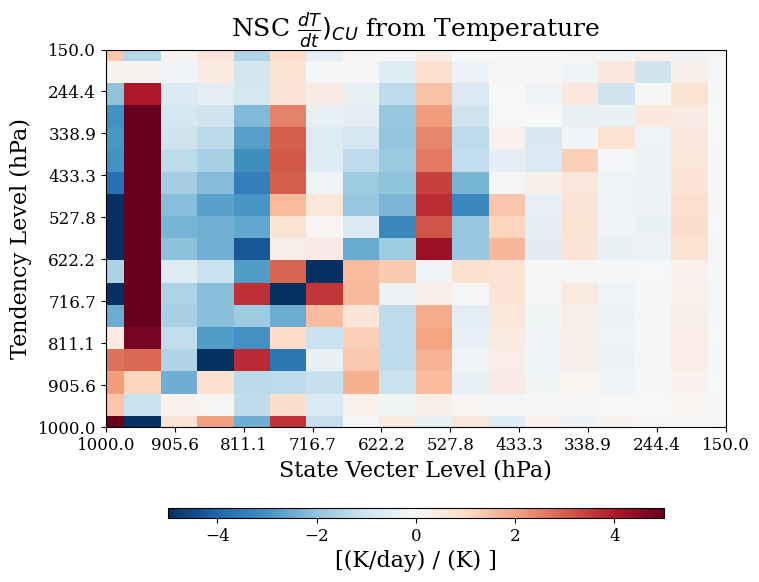

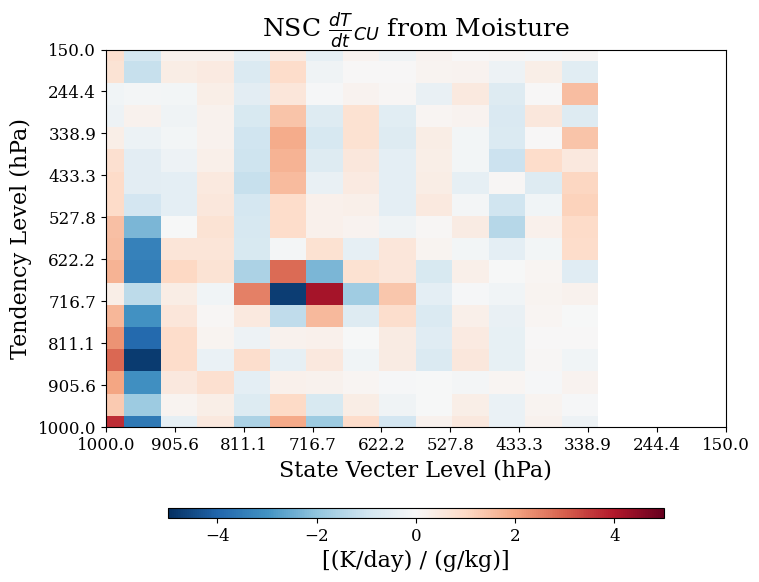

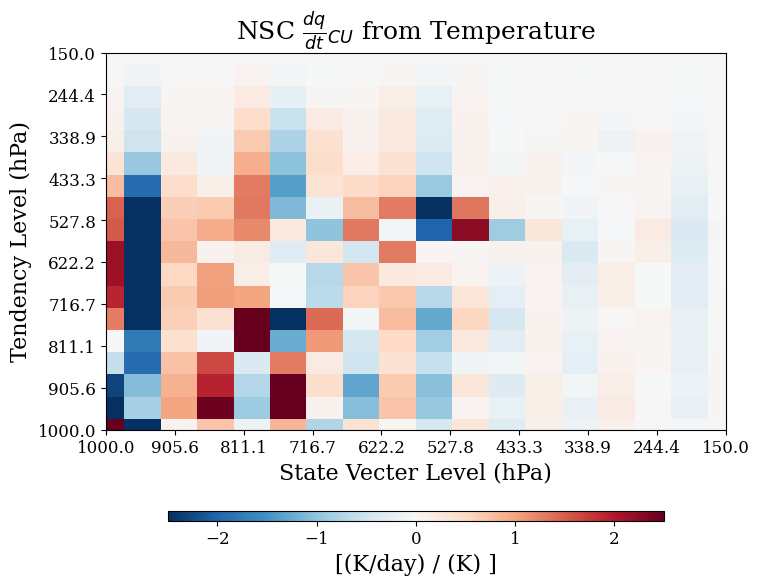

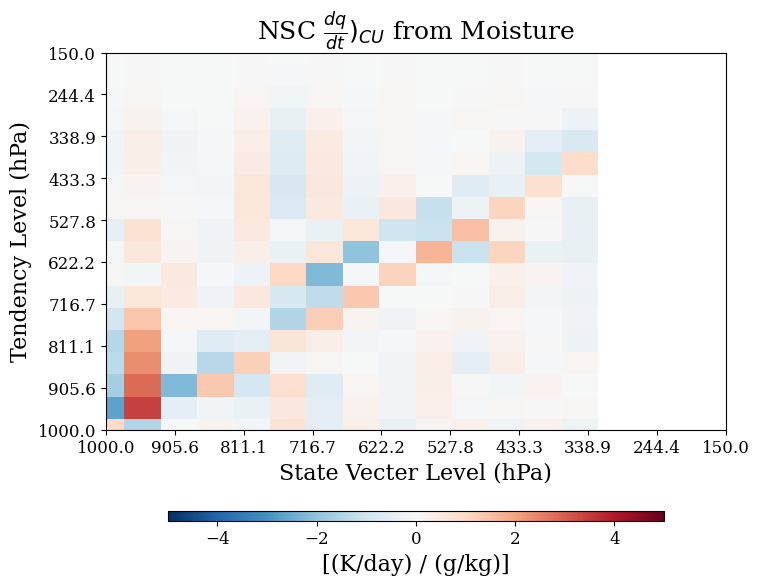

In [147]:
## longwave effect
### T - T
plt.figure(figsize=(8, 7))
plt.pcolormesh(lev_itp, lev_itp, lw_lrf[:, :half], cmap="RdBu_r", vmin=-1.5, vmax=1.5)
plt.xticks(np.linspace(150, 1000, 10))
plt.yticks(np.linspace(150, 1000, 10))
plt.xlim(1000, 150)
plt.ylim(1000, 150)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r" $\frac{dT}{dt})_{LW}$ from Temperature")
plt.colorbar(orientation='horizontal', label='[(K/day) / (K) ]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}lw_t_t.png', dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev_itp, lev_itp, lw_lrf[:, half:], cmap="RdBu_r", vmin=-1.5, vmax=1.5)
plt.xticks(np.linspace(150, 1000, 10))
plt.yticks(np.linspace(150, 1000, 10))
plt.xlim(1000, 150)
plt.ylim(1000, 150)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt})_{LW}$ from Moisture')
plt.colorbar(orientation='horizontal', label='[(K/day) / (g/kg)]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}lw_t_q.png', dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev_itp, lev_itp, sw_lrf[:, :half], cmap="RdBu_r", vmin=-3, vmax=3)
plt.xticks(np.linspace(150, 1000, 10))
plt.yticks(np.linspace(150, 1000, 10))
plt.xlim(1000, 150)
plt.ylim(1000, 150)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt})_{SW}$ from Temperature')
plt.colorbar(orientation='horizontal', label='[(K/day) / (K) ]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}sw_t_t.png', dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev_itp, lev_itp, sw_lrf[:, half:], cmap="RdBu_r", vmin=-3, vmax=3)
plt.xticks(np.linspace(150, 1000, 10))
plt.yticks(np.linspace(150, 1000, 10))
plt.xlim(1000, 150)
plt.ylim(1000, 150)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt})_{SW}$ from Moisture')
plt.colorbar(orientation='horizontal', label='[(K/day) / (g/kg)]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}sw_t_q.png', dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev_itp, lev_itp, cu_lrf[:half, :half], cmap="RdBu_r", vmin=-5, vmax=5)
plt.xticks(np.linspace(150, 1000, 10))
plt.yticks(np.linspace(150, 1000, 10))
plt.xlim(1000, 150)
plt.ylim(1000, 150)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt})_{CU}$ from Temperature')
plt.colorbar(orientation='horizontal', label='[(K/day) / (K) ]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}cu_t_t.png', dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev_itp, lev_itp, cu_lrf[:half, half:], cmap="RdBu_r", vmin=-5, vmax=5)
plt.xticks(np.linspace(150, 1000, 10))
plt.yticks(np.linspace(150, 1000, 10))
plt.xlim(1000, 150)
plt.ylim(1000, 150)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dT}{dt}_{CU}$ from Moisture')
plt.colorbar(orientation='horizontal', label='[(K/day) / (g/kg)]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}cu_t_q.png', dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev_itp, lev_itp, cu_lrf[half:, :half], cmap="RdBu_r", vmin=-2.5, vmax=2.5)
plt.xticks(np.linspace(150, 1000, 10))
plt.yticks(np.linspace(150, 1000, 10))
plt.xlim(1000, 150)
plt.ylim(1000, 150)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dq}{dt}_{CU}$ from Temperature')
plt.colorbar(orientation='horizontal', label='[(K/day) / (K) ]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}cu_q_t.png', dpi=500)
plt.show()
plt.close()

plt.figure(figsize=(8, 7))
plt.pcolormesh(lev_itp, lev_itp, cu_lrf[half:, half:], cmap="RdBu_r", vmin=-5, vmax=5)
plt.xticks(np.linspace(150, 1000, 10))
plt.yticks(np.linspace(150, 1000, 10))
plt.xlim(1000, 150)
plt.ylim(1000, 150)
plt.xlabel('State Vecter Level (hPa)')
plt.ylabel('Tendency Level (hPa)')
plt.title(case+r' $\frac{dq}{dt})_{CU}$ from Moisture')
plt.colorbar(orientation='horizontal', label='[(K/day) / (g/kg)]', aspect=50, shrink=0.8)
plt.savefig(f'{image_path}cu_q_q.png', dpi=500)
plt.show()
plt.close()
